<h1 style="text-align: center;"><b>PROG8245 - ML PROGRAMMING</h1>

<h2 style="text-align: center;">Final Project</h2>
</b>
<h3 style="text-align: center; margin-top: 40px;"><b>Sentiment Analysis on Amazon Food Reviews</b></h3>
<br>
<table style="margin-left: auto; margin-right: auto; border-collapse: collapse; font-size: 18px;">
  <tr>
    <th colspan="3" style="padding: 10px; border: 1px solid black;">Project Members</th>
  </tr>
  <tr>
    <td style="padding: 10px; border: 1px solid black;">MOHAMMED ADEEN SHAIK</td>
    <td style="padding: 10px; border: 1px solid black;">ABDUR RAHMAN SHAIK</td>
    <td style="padding: 10px; border: 1px solid black;">VAIBHAV SHARMA</td>
  </tr>
</table>

### <b> 1.Data Collection

<h2 style="text-align: center; margin-top: 50px;">Objective</h2>

<p style="text-align: justify; font-size: 16px;">
  The objective of this project is to apply Natural Language Processing techniques to perform
  a multiclass sentiment analysis on Amazon food reviews. Specifically, the project will:
</p>

<ul style="font-size: 16px; line-height: 1.5;">
  <li>Collect and annotate a corpus of product reviews as positive, negative, or neutral.</li>
  <li>Carry out text preprocessing steps including tokenization, stop‑word removal, lowercasing, and stemming/lemmatization.</li>
  <li>Experiment with three distinct feature‑extraction methods (e.g., Bag‑of‑Words, TF‑IDF, and contextual embeddings such as BERT).</li>
  <li>Build and evaluate classification models (such as Naïve Bayes, SVM, or neural networks) on the extracted features.</li>
  <li>Compare model performance to determine the most effective embedding technique for review sentiment classification.</li>
  <li>Document the methodology, results, and insights, and present findings in a final report and live demonstration.</li>
</ul>

Dataset Source: <a href="https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews"> Kaggle: Amazon Fine Food Reviews</a>

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snap/amazon-fine-food-reviews")

print("Path to dataset files:", path)

c:\Users\Alienware\Desktop\AAIMl\CSCN8010\CSCN8010\venv\CSCN8010_classical_ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\Alienware\.cache\kagglehub\datasets\snap\amazon-fine-food-reviews\versions\2


In [2]:
import pandas as pd

# Load the dataset
reviews_data = pd.read_csv(path + "/Reviews.csv")

In [3]:
reviews_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
reviews_data.shape

(568454, 10)

In [28]:
# As you can see the data is too large to work with in memory. So we will use a sample of the data to train our model.

# Sample 10,000 rows from the dataset

sampled_data = reviews_data.sample(n=10000, random_state=32)
sampled_data.shape

(10000, 10)

In [29]:
from transformers import pipeline

classifier = pipeline("text-classification", model="cardiffnlp/twitter-roberta-base-sentiment")

Device set to use cpu


In [30]:
NEUTRAL_THRESHOLD = 0.5

def get_sentiment(text):
    result = classifier(text[:512])[0]
    label, score = result["label"], result["score"]

    if score < NEUTRAL_THRESHOLD:
        return "neutral"
    # then map each label explicitly:
    if label == "LABEL_0":
        return "negative"
    if label == "LABEL_1":
        return "neutral"
    if label == "LABEL_2":
        return "positive"
    # (add a catch‑all if you really want)
    return "neutral"
    
# Apply the sentiment analysis annotation function to the sampled data
sampled_data['Category'] = sampled_data['Text'].apply(get_sentiment)

In [31]:
sampled_data['Category'].value_counts()

Category
positive    7380
negative    1377
neutral     1243
Name: count, dtype: int64

### <b> 2. Data Processing

In [32]:
import spacy
import re
import emoji
import string
import nltk
from nltk.stem import WordNetLemmatizer

In [33]:
nlp = spacy.load("en_core_web_sm")
lemmatizer = WordNetLemmatizer()

In [34]:
def basic_text_cleaning(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtag symbol but keep words
    text = emoji.replace_emoji(text, replace='')  # Remove emojis
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'\s+', ' ', text).strip()  # Extra whitespace
    return text

In [35]:
def clean_sentences(sentences=None):
    processed_sentences = []
    
    for sentence in sentences:
        sentence = basic_text_cleaning(sentence)  # Apply basic cleaning

        doc = nlp(sentence)  # spaCy parsing
        tokens = []
        
        for token in doc:
            if token.ent_type_:  # Keep named entities as they are
                tokens.append(token.text)
            else:
                tokens.append(token.text.lower())
        
        tokens = [word for word in tokens if word.isalnum()]  # Remove punctuations/symbols
        tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize
        tokens = [token for token in tokens if not nlp.vocab[token].is_stop]  # Stopword removal
        
        processed_sentences.append(' '.join(tokens))  # Re-join if needed for model input

    return processed_sentences

In [36]:
# Convert column to list
sentences = sampled_data['Text'].tolist()

# Processing the sentences
processed = clean_sentences(sentences)

# Add processed column to DataFrame
sampled_data['Processed_Text'] = processed

In [37]:
sampled_data.sample(5, random_state=42)['Text'].values.tolist()

["We've been ordering Raven's Brew coffee for years from their website.  The coffee is expensive but worth it!  The quality is excellent and the beans are always incredibly fresh.  Each blend has subtle differences but they are all terrific.  The only killer was the price of their shipping.<br /><br />I've just noticed today that Amazon is selling this with Prime shipping.  Today just turned into a great day! Recommended!",
 'I have tried several different dark chocolates infused with green tea. This is by far the best.',
 'These potato chips are excellent.There are no trans fats.<br /><br />They taste absolutely delicious.Whenever I am in the mood for potatoe chips, Kettles is the brand I buy.<br /><br />A great product that anyone should enjoy and I highly recommend them!<br /><br />Enjoy!',
 'My wife and I enjoy a pot of Green Chai Tea each morning.  It has a great flavor.  It is a little hard to find in grocery stores at the quantity that we like.  Hint... set it up as a subscripti

In [38]:
sampled_data.sample(5, random_state=42)['Processed_Text'].values.tolist()

['ordering raven brew coffee year website coffee expensive worth quality excellent bean incredibly fresh blend ha subtle difference terrific killer wa price noticed today amazon selling prime shipping today turned great day recommended',
 'tried different dark chocolate infused green tea far best',
 'potato chip trans taste absolutely mood potatoe chip kettle brand great product enjoy highly recommend',
 'wife enjoy pot green chai tea morning ha great flavor little hard find grocery store quantity like hint set subscription pay grocery store delivered door',
 'review cookie price set seller cookie fantastic perfect little treat cooky calorie trying watch weight eat calorie perfect time need sugary chocolately eat blow entire day yum']

### <b>3. Feature Extraction and Model Comparison

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

# Create BoW vectorizer
bow_vectorizer = CountVectorizer(max_features=5000)  

# Fit and transform the text data
bow_features = bow_vectorizer.fit_transform(sampled_data['Processed_Text'])

# Check shape
print(bow_features.shape)  # Output: (num_samples, 5000)

(10000, 5000)


In [40]:
# Convert to DataFrame for better visualization
bow_df = pd.DataFrame(bow_features.toarray(), columns=bow_vectorizer.get_feature_names_out())
bow_df.head(5)

,ability,able,absolute,absolutely,absorb,absorbed,absorbs,abundant,acai,accept,...,zinger,zip,ziploc,ziplock,zipper,ziti,zoe,zone,zuke,zukes
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for performance

# Fit and transform the text data
tfidf_features = tfidf_vectorizer.fit_transform(sampled_data['Processed_Text'])

print(tfidf_features.shape)  # (n_samples, n_features)

(10000, 5000)


In [42]:
# Convert to DataFrame for better visualization
tfidf_df = pd.DataFrame(tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head(5)

,ability,able,absolute,absolutely,absorb,absorbed,absorbs,abundant,acai,accept,...,zinger,zip,ziploc,ziplock,zipper,ziti,zoe,zone,zuke,zukes
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained BERT model for sentence embeddings
bert_model = SentenceTransformer('all-MiniLM-L6-v2')  # this is a smaller model for faster inference

# Generate BERT embeddings for all sentences
bert_embeddings = bert_model.encode(sampled_data['Processed_Text'].tolist(), show_progress_bar=True)


Batches: 100%|██████████| 313/313 [01:03<00:00,  4.91it/s]


In [44]:
# Convert to DataFrame for better visualization
bert_embeddings_df = pd.DataFrame(bert_embeddings)
bert_embeddings_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,374,375,376,377,378,379,380,381,382,383
0,-0.103915,0.010839,0.082461,-0.008956,-0.020587,-0.015238,0.072961,-0.009415,-0.017700,-0.074539,...,-0.029645,0.008708,-0.006515,-0.048819,-0.042665,-0.000943,0.081005,-0.067181,-0.080731,-0.011862
1,-0.039819,0.004960,0.066812,0.021738,0.039662,0.003383,-0.011161,-0.012550,-0.000475,-0.084619,...,0.013280,-0.054505,0.048551,-0.023641,0.019538,-0.049750,0.050235,-0.051495,0.064028,-0.030657
2,-0.077267,0.012415,0.067779,0.031524,-0.059942,0.027524,0.056312,0.012963,0.018784,-0.021633,...,0.042992,-0.071414,0.039601,-0.006321,0.060141,-0.017721,0.070446,-0.075330,0.002978,0.107072
3,-0.013996,-0.089745,0.048541,-0.011702,-0.037408,-0.001818,0.107862,0.042044,0.070771,-0.042454,...,0.000464,-0.024908,-0.013671,-0.000285,-0.019355,-0.039605,0.109883,0.026189,-0.010818,-0.020298
4,0.038250,-0.069968,0.017914,0.028871,0.011928,0.062575,0.041814,0.103841,0.025129,-0.009648,...,-0.002307,-0.006386,0.002150,-0.034691,-0.061384,0.048930,0.001235,-0.022687,0.064937,0.057156


In [45]:
import numpy as np

X_bow = bow_features.toarray()
X_tfidf = tfidf_features.toarray()
X_bert = np.array(bert_embeddings)

y = sampled_data['Category']  # Already annotated (positive, negative, neutral)

# Encode labels
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train_bow, X_test_bow, y_train, y_test = train_test_split(X_bow, y_encoded, test_size=0.2, random_state=42)
X_train_tfidf, X_test_tfidf = train_test_split(X_tfidf, test_size=0.2, random_state=42)
X_train_bert, X_test_bert = train_test_split(X_bert, test_size=0.2, random_state=42)


In [46]:
#Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Initialize the model
nb_model = MultinomialNB()

# Train the model using Bag of Words features
nb_model.fit(X_train_bow, y_train)

# Make predictions
y_pred_bow = nb_model.predict(X_test_bow)


In [47]:
def print_metrics(name, y_true, y_pred):
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

In [48]:
print_metrics("Bag of Words", y_test, y_pred_bow)


Model: Bag of Words
Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

    negative       0.52      0.52      0.52       256
     neutral       0.28      0.22      0.24       234
    positive       0.87      0.90      0.88      1510

    accuracy                           0.77      2000
   macro avg       0.56      0.55      0.55      2000
weighted avg       0.76      0.77      0.76      2000



In [49]:
# using TF-IDF features on SVM Model
from sklearn.svm import SVC
# Initialize the model
svm_model = SVC(kernel='linear', random_state=42)
# Train the model using TF-IDF features
svm_model.fit(X_train_tfidf, y_train)
# Make predictions
y_pred_svm = svm_model.predict(X_test_tfidf)
print_metrics("SVM with TF-IDF", y_test, y_pred_svm)


Model: SVM with TF-IDF
Accuracy: 0.8075
Classification Report:
              precision    recall  f1-score   support

    negative       0.67      0.49      0.57       256
     neutral       0.43      0.06      0.10       234
    positive       0.83      0.98      0.90      1510

    accuracy                           0.81      2000
   macro avg       0.64      0.51      0.52      2000
weighted avg       0.76      0.81      0.76      2000



In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'solver': ['liblinear', 'saga', 'lbfgs'],
    'C': [0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l2']  # L1 works only with saga/liblinear
}

# Setup Logistic Regression
lr = LogisticRegression(max_iter=1000)

# Grid Search
grid = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid.fit(X_train_bert, y_train)

# Best model
best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

# Predict
y_pred_bert = best_model.predict(X_test_bert)

# Evaluate
print_metrics("Optimized BERT + Logistic Regression", y_test,y_pred_bert)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

Model: Optimized BERT + Logistic Regression
Accuracy: 0.799
Classification Report:
              precision    recall  f1-score   support

    negative       0.61      0.46      0.52       256
     neutral       0.44      0.09      0.14       234
    positive       0.83      0.97      0.89      1510

    accuracy                           0.80      2000
   macro avg       0.63      0.50      0.52      2000
weighted avg       0.76      0.80      0.76      2000



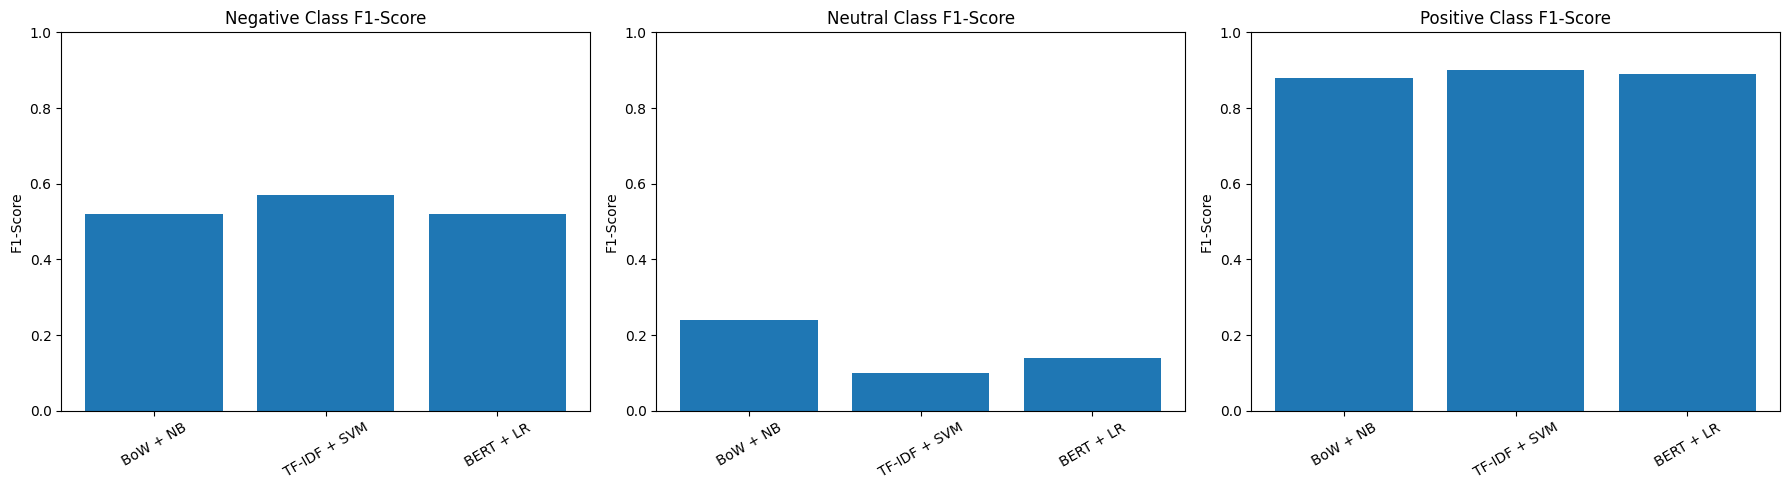

In [52]:
import matplotlib.pyplot as plt

# Model labels and F1-scores
models = ['BoW + NB', 'TF-IDF + SVM', 'BERT + LR']
negative_f1 = [0.52, 0.57, 0.52]
neutral_f1  = [0.24, 0.10, 0.14]
positive_f1 = [0.88, 0.90, 0.89]

# Create 1×3 subplots (each with its own y-axis)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot Negative
axes[0].bar(models, negative_f1)
axes[0].set_title('Negative Class F1-Score')
axes[0].set_ylabel('F1-Score')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=30)

# Plot Neutral
axes[1].bar(models, neutral_f1)
axes[1].set_title('Neutral Class F1-Score')
axes[1].set_ylabel('F1-Score')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=30)

# Plot Positive
axes[2].bar(models, positive_f1)
axes[2].set_title('Positive Class F1-Score')
axes[2].set_ylabel('F1-Score')
axes[2].set_ylim(0, 1)
axes[2].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

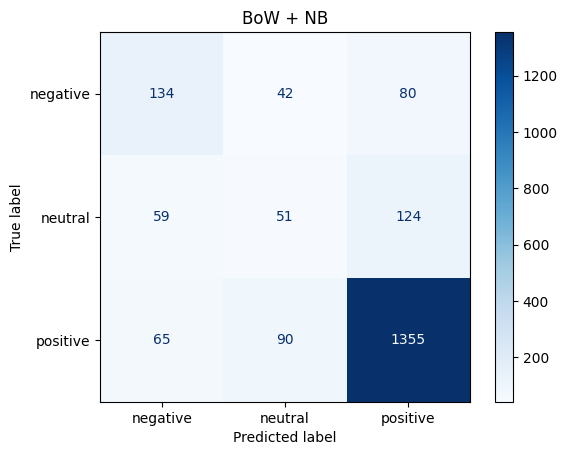

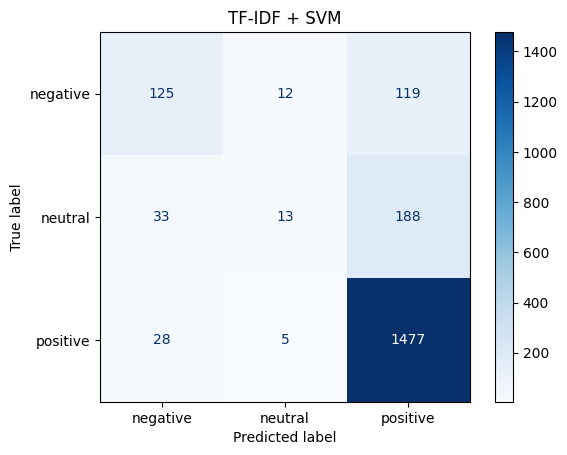

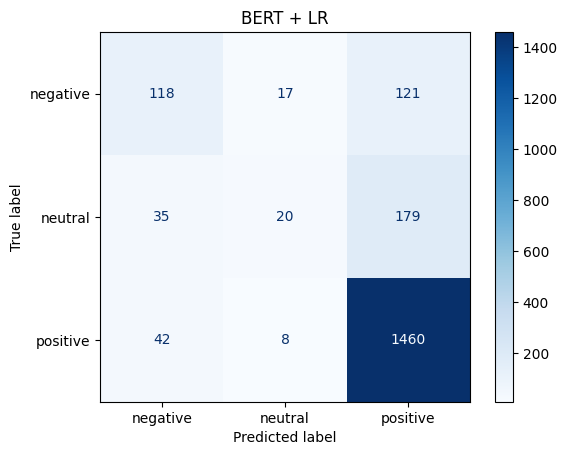

In [57]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Quick loop to plot all three confusion matrices
model_preds = [
    ("BoW + NB", y_pred_bow),
    ("TF-IDF + SVM", y_pred_svm),
    ("BERT + LR", y_pred_bert),
]

for name, preds in model_preds:
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        preds,
        display_labels=le.classes_,
        cmap='Blues',
        values_format='d'
    )
    disp.ax_.set_title(name)
    plt.show()
